<a href="https://colab.research.google.com/github/jamc88/Signal-Detection-in-FAERS-Pharmacovigilance/blob/main/An%C3%A1lisis_datos_q4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tarea 2
Mismo código, diferentes datos Q4 y diferente análisis


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive

In [2]:
#Montamos el drive
drive.mount('/content/drive', force_remount=True)
base_path = Path("/content/drive/MyDrive/Proyecto_Terminal_2/Datos_Q4")


Mounted at /content/drive


In [3]:
base = Path("/content/drive/MyDrive/Proyecto_Terminal_2/Datos_Q4") #ruta
# Leemos asegurando que el ID sea texto (string)
reports = pd.read_csv(base/"q4_reports_100k.csv", dtype={"safetyreportid":"string"})

drugs = pd.read_csv(base/"q4_drugs_100k.csv", dtype={"safetyreportid":"string"})

reactions = pd.read_csv(base/"q4_reactions_100k.csv", dtype={"safetyreportid":"string"})

#AUDITORÍA
#imprimimos cuántas filas tiene cada archivo
print("filas:", {"reports": len(reports), "drugs": len(drugs), "reactions": len(reactions)})
#contamos cuántos IDs únicos hay (deberían ser 100,000 a fuerza)
print("ID's únicos en los informes:", reports["safetyreportid"].nunique())

#si hay identificadores vacíos (nulos) en cada tabla
print("tasas de identificación nula:", {
    "reports": reports["safetyreportid"].isna().mean(),   # Promedio de nulos en reportes
    "drugs": drugs["safetyreportid"].isna().mean(),       # Promedio de nulos en drogas
    "reactions": reactions["safetyreportid"].isna().mean(), # Promedio de nulos en reacciones
})


# Verificamos si hay drogas cuyo ID no existe en la tabla de reportes (debería ser 0)
print("Medicamentos que no aparecen en los informes:", (~drugs["safetyreportid"].isin(reports["safetyreportid"])).sum())
# Verificamos si hay reacciones cuyo ID no existe en la tabla de reportes igual deben ser 0
print("Reacciones que no aparecen en los informes:", (~reactions["safetyreportid"].isin(reports["safetyreportid"])).sum())

#LIMPIEZA DE STRINGS (TEXTO)
# Normalizamos nombres de medicamentos a mayúsculas y sin espacios extra
for col in ["medicinalproduct", "activesubstancename"]:
    if col in drugs.columns: # Solo si la columna existe
        drugs[col] = drugs[col].astype("string").str.strip().str.upper()

#nombres de las reacciones a mayúsculas
reactions["reaction_pt"] = reactions["reaction_pt"].astype("string").str.strip().str.upper()

#CREACIÓN DE LLAVE DE MEDICAMENTO
# Creamos una columna 'drug_key': Si hay Ingrediente Activo, usa ese; si no, usa el Nombre Comercial.
drugs["drug_key"] = drugs["activesubstancename"].fillna(drugs["medicinalproduct"]).astype("string").str.strip().str.upper()


# Eliminamos duplicados dentro del mismo reporte (si el mismo ID reporta la misma droga 2 veces, cuenta como 1)
drugs_u = drugs[["safetyreportid","drug_key"]].dropna().drop_duplicates()
# Lo mismo para las reacciones
reac_u  = reactions[["safetyreportid","reaction_pt"]].dropna().drop_duplicates()

# Imprimimos los conteos finales únicos
print("filas de medicamentos únicos:", len(drugs_u))
print("filas de reacción únicas:", len(reac_u))

filas: {'reports': 100000, 'drugs': 508637, 'reactions': 351545}
ID's únicos en los informes: 100000
tasas de identificación nula: {'reports': np.float64(0.0), 'drugs': np.float64(0.0), 'reactions': np.float64(0.0)}
Medicamentos que no aparecen en los informes: 0
Reacciones que no aparecen en los informes: 0
filas de medicamentos únicos: 317346
filas de reacción únicas: 347276


Al obtener nuevamente 100,000 IDs únicos con una tasa de nulos del 0%, validamos que el proceso de extracción funcionó sin errores: no hay id corruptos ni reportes vacío, asegura que cada evento adverso y cada fármaco listado está correctamente vinculado a un paciente específico, como ya habíamos observado en otros trimestres.


Inicialmente, el sistema cargó 508637 registros de medicamentos y despues de la limpieza y deduplicación por reporte, la cifra fue a 317346.

Luego la tabla de reacciones mostró que paso de 351,545 registros crudos a 347,276 únicos, muy poco

Esto indica que el campo de eventos adversos suele ser llenado de manera concisa


In [4]:
# Volvemos a definir la base por seguridad como en el orig.
base = Path("/content/drive/MyDrive/Proyecto_Terminal_2/Datos_Q4")

reports = pd.read_csv(base/"q4_reports_100k.csv", dtype={"safetyreportid":"string"})
drugs = pd.read_csv(base/"q4_drugs_100k.csv", dtype={"safetyreportid":"string"})
reactions = pd.read_csv(base/"q4_reactions_100k.csv", dtype={"safetyreportid":"string"})

#LIMPIEZA RÁPIDA
#normalizamos a mayúsculas nuevamente para el conteo
for col in ["medicinalproduct", "activesubstancename"]:
    drugs[col] = drugs[col].astype("string").str.strip().str.upper()
reactions["reaction_pt"] = reactions["reaction_pt"].astype("string").str.strip().str.upper()

#Seleccionamos columnas clave y quitamos duplicados
drugs_u = drugs[["safetyreportid","activesubstancename","medicinalproduct"]].drop_duplicates()
reac_u  = reactions[["safetyreportid","reaction_pt"]].drop_duplicates()

#agrupamos por ID y contamos el tamaño (cuántos items tiene cada ID)
drugs_per_report = drugs_u.groupby("safetyreportid").size()
reac_per_report  = reac_u.groupby("safetyreportid").size()

# Imprimimos los percentiles para ver la distribución (Mediana, 90%, 99%)
print("Drugs/report percentiles:\n", drugs_per_report.quantile([.5,.75,.9,.95,.99]))
print("Reactions/report percentiles:\n", reac_per_report.quantile([.5,.75,.9,.95,.99]))

Drugs/report percentiles:
 0.50     1.0
0.75     3.0
0.90     7.0
0.95    12.0
0.99    28.0
dtype: float64
Reactions/report percentiles:
 0.50     2.0
0.75     4.0
0.90     7.0
0.95    10.0
0.99    25.0
dtype: float64


Aqui se realiza una deduplicación para contar las únicas; es decir, si un reporte menciona el mismo medicamento tres veces, el código lo reduce a una sola mención para medir la exposición real.

En cuanto a los medicamentos la mediana (percentil 0.50) se sitúa en 1, nuevamente
"Si ordenamos todos los reportes de menor a mayor, al llegar a la mitad exacta (el 50%), encontramos que ese reporte tiene 1 medicamento".

En resumen justo en la mitad el valor es 1, lo que significa que la mitad de los reportes tienen 1 medicamento o droga.

Sin embargo, la distribución crece exponencialmente hacia los extremos; el percentil 95 muestra 12 medicamentos, y el percentil 99 da  28.0 medicamentos por reporte, muy similar al Q2

Por otro lado, las reacciones adversas muestran una mediana de 2.0, lo que significa que el caso típico describe un cuadro clínico puntual con un par de síntomas.


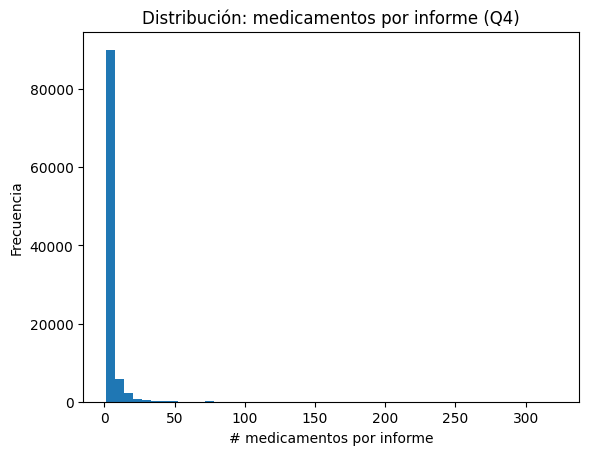

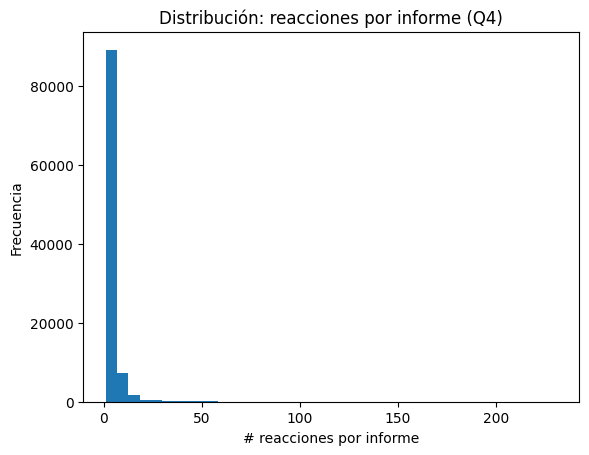

In [10]:
plt.figure()
plt.hist(drugs_per_report, bins=50)              #histograma con 100 barras
plt.xlabel("# medicamentos por informe")
plt.ylabel("Frecuencia")
plt.title("Distribución: medicamentos por informe (Q4)")
#plt.ylim(0,100)                                  # Límite del eje Y
plt.show()

#REACCIONES
plt.figure()
plt.hist(reac_per_report, bins=40)
plt.xlabel("# reacciones por informe")
plt.ylabel("Frecuencia")
#plt.ylim(0,100)
plt.title("Distribución: reacciones por informe (Q4)")
plt.show()

Los datos del Q4 posee una estructura de distribución asimétrica positiva, osea cola larga.
Confirmamos con el percentil 50 o mediana, que muestra que la mitad de la población reportada estuvo expuesta a un único medicamento y manifestó apenas dos reacciones adversas.

In [11]:
#calculamos qué porcentaje tiene nombre de sustancia activa válido (no nulo y largo > 0)
active_nonnull = drugs["activesubstancename"].notna() & (drugs["activesubstancename"].str.len() > 0)
#calculamos qué porcentaje tiene nombre de producto medicinal válido
prod_nonnull   = drugs["medicinalproduct"].notna() & (drugs["medicinalproduct"].str.len() > 0)

#porcentajes de calidad
print("Filas de fracciones con nombre de sustancia activa:", active_nonnull.mean())
print("Filas de fracciones con medicamento:", prod_nonnull.mean())

# Obtenemos el Top 20 de sustancias activas más frecuentes
top_active = drugs.loc[active_nonnull, "activesubstancename"].value_counts().head(20)
# Obtenemos el Top 20 de productos comerciales más frecuentes
top_prod   = drugs.loc[prod_nonnull, "medicinalproduct"].value_counts().head(20)

print("\nTop-20 sustancias activas:")
display(top_active)

print("\nTop-20 productos medicinales:")
display(top_prod)

Filas de fracciones con nombre de sustancia activa: 0.9814543574297584
Filas de fracciones con medicamento: 1.0

Top-20 sustancias activas:


,count
activesubstancename,
TIRZEPATIDE,14242
DUPILUMAB,13020
INFLIXIMAB,7172
METHOTREXATE,7073
PREDNISONE,6941
ACETAMINOPHEN,6157
VEDOLIZUMAB,5800
TOCILIZUMAB,5054
RITUXIMAB,4966



Top-20 productos medicinales:


,count
medicinalproduct,
DUPIXENT,12837
MOUNJARO,7205
METHOTREXATE,7055
PREDNISONE,6923
ZEPBOUND,6866
INFLIXIMAB,5698
VEDOLIZUMAB,5223
RITUXIMAB,4640
ACETAMINOPHEN,4108


Calidad de nombres
Se hace Calidad de nombres para asegurarte de que la “variable fármaco” (D) y, en menor medida, la “variable evento” (A) son comparables y consistentes antes de contar coocurrencias y calcular señales (PRR/ROR/IC).

En FAERS los nombres vienen con variaciones (marca vs genérico, mayúsculas, espacios, abreviaturas, “UNKNOWN”, etc.). Si no se revisa esto, se puede terminar contando como distintos lo que es lo mismo, o mezclando basura con datos reales.


Top-20 reacciones (PT):


,count
reaction_pt,
OFF LABEL USE,7314
DRUG INEFFECTIVE,5872
PRODUCT DOSE OMISSION ISSUE,4526
FATIGUE,4183
NAUSEA,3923
DIARRHOEA,3888
DEATH,3390
HEADACHE,3232
PRURITUS,3066


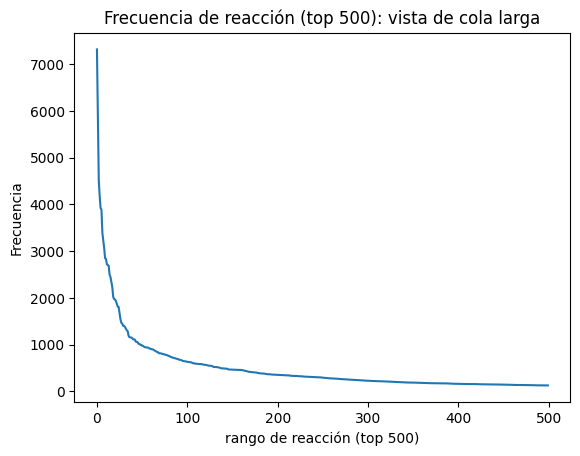

In [12]:
#frecuencia de cada reacción adversa
top_reac = reactions["reaction_pt"].value_counts()

# Mostramos el Top 20
print("\nTop-20 reacciones (PT):")
display(top_reac.head(20))

#gráfica de línea de la "Cola Larga" (primeras 500 reac)
plt.figure()
plt.plot(top_reac.values[:500])                   # Grafica los valores
plt.xlabel("rango de reacción (top 500)")         # Eje X
plt.ylabel("Frecuencia")                          # Eje Y
plt.title("Frecuencia de reacción (top 500): vista de cola larga") # Título
plt.show()

Se hace frecuencia y cola larga para entender cómo están distribuidos los eventos (y fármacos) y cómo eso afecta la confiabilidad de las señales.

En FAERS casi siempre pasa esto: pocos términos aparecen muchísimo y muchísimos términos aparecen muy poco. Eso es la “cola larga”.


Lo que podemos resumir de la gráfica de cola larga es que en la primera seccion de la izquierda, que es donde vemos el pico es que hay muy pocos efectos secundarios que les ocurren a muchas personas como el dolor de cabeza; por otro lado cuando empieza a decaer hay muchismos efectos secundarios diferentes que les pasan a muy pocas personas, similar a los trimestres anteriores.

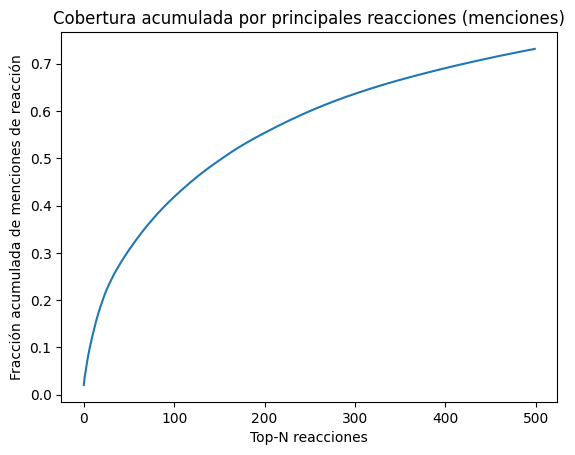

In [13]:
#suma acumulada para ver qué % del total cubren las top N reacciones
cum = top_reac.cumsum() / top_reac.sum()

# Generamos la gráfica
plt.figure()
plt.plot(cum.values[:500])                        # Grafica la curva acumulada
plt.xlabel("Top-N reacciones")                    # Eje X
plt.ylabel("Fracción acumulada de menciones de reacción") # Eje Y
plt.title("Cobertura acumulada por principales reacciones (menciones)") # Título
plt.show()

La gráfica de cobertura acumulada complementa la distribución de frecuencia, permitiéndonos cuantificar qué proporción del volumen total de información está contenida en las reacciones más comunes.
La curva asciende rápidamente en el eje Y con un número relativamente pequeño de reacciones en el eje X, específicamente, se observa que las Top-500 reacciones logran cubrir aproximadamente arriba del 70% del total de menciones registradas en la base de datos del Q2.

 Significa que al enfocar el análisis en estos términos frecuentes, se está capturando la inmensa mayoría de la evidencia disponible. Por otro lado, la existencia de ese 25% aprox residual disperso justifica plenamente la implementación de umbrales mínimos de soporte como exigir al menos 3 o 5 casos para considerar una señal.


Top-10 occurcountry:


,count
occurcountry,
US,58526
EU,10775
CA,6033
JP,4308
GB,3907
CN,2389
AU,808
IN,636
BR,623



Parsed receiptdate valid fraction: 1.0


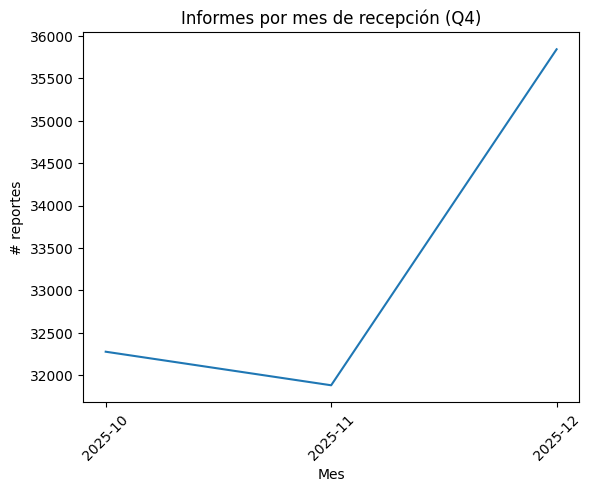

In [15]:
#PAÍSES
if "occurcountry" in reports.columns:             # Si la columna existe
    print("\nTop-10 occurcountry:")               #imprime título
    # Muestra los 10 países más frecuentes
    display(reports["occurcountry"].astype("string").str.strip().str.upper().value_counts().head(10))

#FECHAS (RECEIPTDATE)
if "receiptdate" in reports.columns:              # Si la columna existe...
    r = reports["receiptdate"].astype("string").str.strip() # Limpia espacios
    #formato AñoMesDia
    dt = pd.to_datetime(r, format="%Y%m%d", errors="coerce")

    # Imprime qué porcentaje de fechas son válidas
    print("\nParsed receiptdate valid fraction:", dt.notna().mean())

    # Si hay fechas válidas, grafica la evolución por mes
    if dt.notna().any():
        # Agrupa por mes y cuenta
        counts = dt.dt.to_period("M").value_counts().sort_index()

        plt.figure()
        plt.plot(counts.index.astype(str), counts.values) # Grafica línea temporal
        plt.xlabel("Mes")
        plt.ylabel("# reportes")
        plt.title("Informes por mes de recepción (Q4)")
        plt.xticks(rotation=45)                   # Rota las etiquetas del eje X para que se lean mejor
        plt.show()

La gráfica de distribución temporal para el cuarto trimestre nos permite ver una línea que decae desde los 32,300 hasta valores menores de 32,000,Sin embargo, al observar despues de octubre se identifica un patrón de crecimiento, el volumen de reportes da un salto de reportes en noviembre hasta llegar a un pico en diciembre en el intervalo de 35,500_36,000.

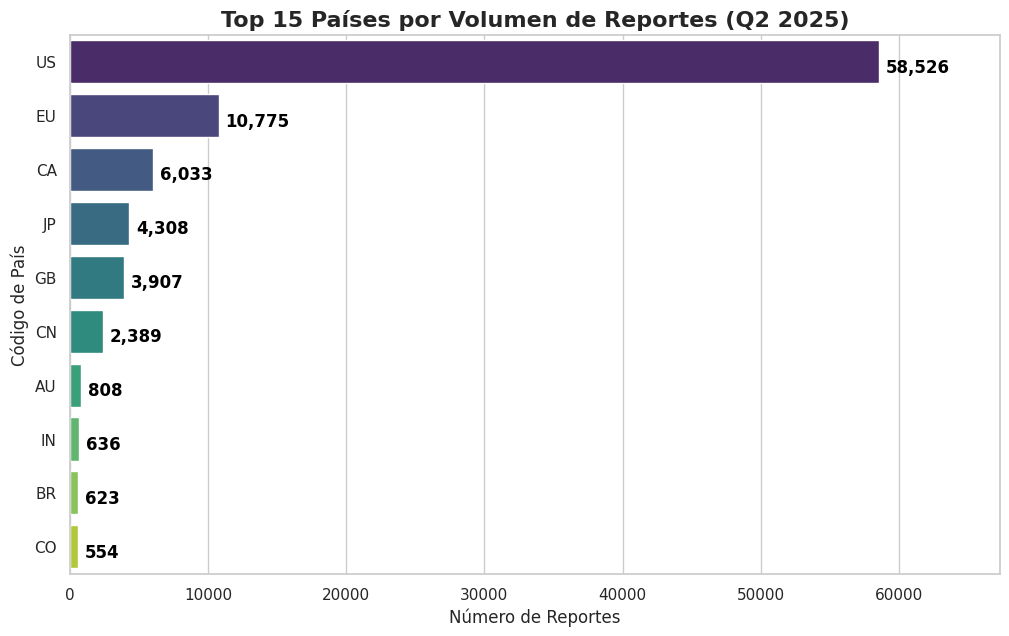

In [16]:
import seaborn as sns

#tomo top 10 para no saturar
if "occurcountry" in reports.columns:
    country_counts = reports["occurcountry"].astype("string").str.strip().str.upper().value_counts().reset_index()
    country_counts.columns = ["País", "Reportes"]
    top_countries = country_counts.head(10)


    plt.figure(figsize=(12, 7))

    #usamos Seaborn
    sns.set_theme(style="whitegrid")
    barplot = sns.barplot(data=top_countries, x="Reportes", y="País",
                          palette="viridis", hue="País", legend=False)

    # Añadimos los números al final de cada barra (para que se lea mas fácil)
    for i, p in enumerate(barplot.patches):
        width = p.get_width()
        plt.text(width + 500,
                 p.get_y() + p.get_height()/2 + 0.1,
                 '{:,.0f}'.format(width), # Formato del número (con comas)
                 ha="left", va="center", fontweight='bold', color='black')

    plt.title("Top 15 Países por Volumen de Reportes (Q2 2025)", fontsize=16, fontweight='bold')
    plt.xlabel("Número de Reportes", fontsize=12)
    plt.ylabel("Código de País", fontsize=12)
    plt.xlim(0, top_countries["Reportes"].max() * 1.15) # Dar espacio extra
    plt.show()

else:
    print("No se encontró la columna 'occurcountry' en el archivo.")

Como era de esperarse al igual que los otros trimestres tendemos una tendencia en los Estados Unidos seguido de @